In [10]:
import sys
pip = "/".join(sys.executable.split("/")[:-1])+"/pip"
!$pip install --upgrade git+https://github.com/rramosp/rlxml
!$pip install --upgrade git+https://github.com/rramosp/rlxutils

  Cloning https://github.com/rramosp/rlxml to /tmp/pip-req-build-a55i5_6l
  Running command git clone -q https://github.com/rramosp/rlxml /tmp/pip-req-build-a55i5_6l
  Created wheel for rlxml: filename=rlxml-0.1.0-py3-none-any.whl size=18816 sha256=57bb17c9c737cb0ba5a60cb828f4ff2983cb2b7e18ed2aa53e26ac2c5aceae5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-46bsema9/wheels/fb/f5/9d/9e2d9eb3660e4a7b9b7dac84bfe42f0a28b0e180a252cd37ea
Successfully built rlxml
  Cloning https://github.com/rramosp/rlxutils to /tmp/pip-req-build-mpvk6iuo
  Running command git clone -q https://github.com/rramosp/rlxutils /tmp/pip-req-build-mpvk6iuo


  Created wheel for rlxutils: filename=rlxutils-0.0.1-py3-none-any.whl size=3331 sha256=38af32369ec0003967dc5c2637b5a985670b4b721d8b3e8f85aea136872600d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-l4vaot14/wheels/32/fc/45/0f0a86abc05fd23b44890963251daad9df596b8f69b603b65d
Successfully built rlxutils
  Attempting uninstall: rlxutils
    Found existing installation: rlxutils 0.0.1
    Uninstalling rlxutils-0.0.1:
      Successfully uninstalled rlxutils-0.0.1


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from progressbar import progressbar as pbar
from scipy import stats
from rlxml import newphysics as phy
from importlib import reload
from joblib import delayed
import rlxutils
import pandas as pd
%matplotlib inline
reload(phy)

<module 'rlxml.newphysics' from '/opt/anaconda/envs/p38/lib/python3.8/site-packages/rlxml/newphysics.py'>

- 10000 events background
- 1000 events señal

- 20 bins de 0 a 1000 (se descartan bins de overflow >1000 y <0)

- background exponential distribution

- signal gaussian distribution: $\mu_s$=650 , $\sigma_s$=10
- background exponential distirbution: 
    - $100e^{-.01x}$ unnormalized
    - $0.01e^{-.01x}$ normalized
    
- sample observation: 

        array([3942, 2352, 1449,  911, 1039,  791,  199,  128,   51,   
              53,   25,  22,   17,    5,   11,    2,    2,    0,    1])

In [2]:
alpha=0.05
t, mu_s, sigma_s, real_mu = 0.01, 225, 10, .5
s_tot, b_tot = 3000, 10000
n_experiments = 2000

n_bins=20
bin_edges = np.r_[list(np.linspace(0,950,n_bins))+[np.inf]]
bin_edges

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550., 600., 650., 700., 750., 800., 850., 900., 950.,  inf])

## continuous model

(0.13043478260869565, 0.8695652173913043)

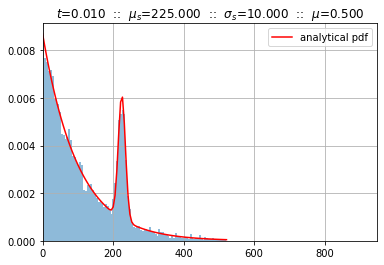

In [60]:
reload(phy)
mc = phy.SignalBg_ContinuousModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=real_mu, 
                                  s_tot = s_tot, b_tot = b_tot)
xc = mc.rvs()
xcb = mc.binarize_sample(xc, bin_edges)
mc.plot_sample(xc, bins=100)
plt.xlim(bin_edges[0], bin_edges[-2])
mc.p_s, mc.p_b

binarize the previous sample

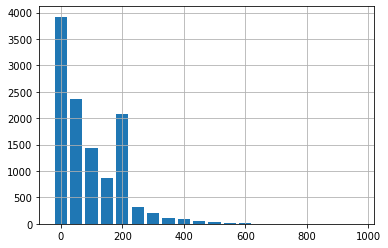

In [61]:
plt.bar(bin_edges[:-1], xcb, 40)
plt.grid();

sample many continuous experiments, then binarize each one and obtain the average histogram

In [58]:
hs = np.r_[[mc.binarize_sample(mc.rvs(), bin_edges) for _  in range(n_experiments)]]

In [59]:
hs.mean(axis=0)

array([3.9366100e+03, 2.3870205e+03, 1.4458435e+03, 8.8717850e+02,
       2.0144235e+03, 3.3179200e+02, 1.9614050e+02, 1.1850150e+02,
       7.1685500e+01, 4.3559500e+01, 2.6440000e+01, 1.6050500e+01,
       9.8110000e+00, 5.9020000e+00, 3.5660000e+00, 2.1770000e+00,
       1.2925000e+00, 8.3950000e-01, 4.4100000e-01, 7.2550000e-01])

## binarized model

In [38]:
reload(phy)

<module 'rlxml.newphysics' from '/Users/rlx/Dropbox/proyectos/rlxlibs/rlxml/rlxml/newphysics.py'>

In [10]:
real_mu = 0.5
mu_s, s_tot, b_tot, real_mu

(225, 3000, 10000, 0.5)

In [11]:
mb = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=real_mu, bin_edges=bin_edges,
                              s_tot = s_tot, b_tot = b_tot)

In [12]:
h = mb.rvs()
h, h.sum()

(array([3861, 2412, 1455,  842, 1972,  332,  199,  125,   68,   36,   22,
          18,    9,    9,    3,    0,    0,    3,    0,    2]),
 11368)

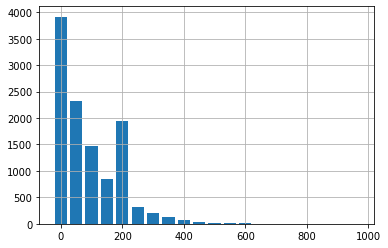

In [65]:
plt.bar(bin_edges[:-1], h, 40)
plt.grid();

In [69]:
mb.n_events, mc.n_events, len(xc), np.sum(xcb)

(11500, 11500, 11500, 11500)

sample many binarized experiments

In [75]:
n_experiments

2000

In [76]:
xb = np.r_[[mb.rvs() for _ in range(10000)]]
xb.mean(axis=0)

array([3.9348200e+03, 2.3866434e+03, 1.4476275e+03, 8.8732350e+02,
       2.0138446e+03, 3.3220150e+02, 1.9592980e+02, 1.1884790e+02,
       7.1904300e+01, 4.3747900e+01, 2.6520600e+01, 1.6085500e+01,
       9.7267000e+00, 5.9586000e+00, 3.5685000e+00, 2.1869000e+00,
       1.3256000e+00, 7.9210000e-01, 4.7780000e-01, 7.1550000e-01])

In [77]:
xb.mean(axis=0).sum()

11500.2482

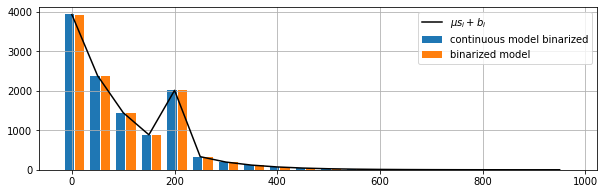

In [79]:
plt.figure(figsize=(10,3))
plt.bar(bin_edges[:-1]-5, hs.mean(axis=0), 18,label="continuous model binarized")
plt.bar(bin_edges[:-1]+15, xb.mean(axis=0), 18, label="binarized model")
plt.plot(bin_edges[:-1], mb.mu*mb.si+mb.bi, color="black", label="$\mu s_i + b_i$")
plt.grid(); plt.legend();


one example histogram from this distribution and its log probability

In [92]:
h = np.r_[3832, 2398, 1446,  883, 2031,  345,  200,  100,   65,   49,   35,
         13,    8,    7,    5,    1,    0,    0,    0,    1]

print ("nb bin_edges", len(bin_edges), "::     nb sampled bins", len(h))
print ("selected sample", h)
print ("random.  sample", mb.rvs())

nb bin_edges 21 ::     nb sampled bins 20
selected sample [3832 2398 1446  883 2031  345  200  100   65   49   35   13    8    7
    5    1    0    0    0    1]
random.  sample [3977 2345 1470  863 2055  331  222  113   64   41   29   17    8    4
    5    4    2    0    0    1]


In [93]:
t, mu_s, sigma_s, s_tot, b_tot

(0.01, 225, 10, 3000, 10000)

In [171]:
reload(phy)
mb = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=2, bin_edges=bin_edges, 
                              s_tot=s_tot, b_tot=b_tot)

In [194]:
x = mb.rvs()
x = h
print ("x = a histogram sampled from the histograms distribution\n", x)

print ("log probability of x given mu ", mb.log_prob(x))
print ("mu_hat: MLE for mu given x    ", mb.get_mu_MLE(x))
print ("t_mu given x                  ", mb.get_t_mu(x))
print ("log prob for x given mu_hat   ", mb.clone().set_mu(mb.get_mu_MLE(x)).log_prob(x))

x = a histogram sampled from the histograms distribution
 [3832 2398 1446  883 2031  345  200  100   65   49   35   13    8    7
    5    1    0    0    0    1]
log probability of x given mu  -2139.689596939992
mu_hat: MLE for mu given x     0.5058966973966352
t_mu given x                   4156.403004159511
log prob for x given mu_hat    -61.48809535468172


In [195]:
%timeit mb.get_mu_MLE(x)

655 µs ± 8.54 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [196]:
mu_hat_distribution = [mb.get_mu_MLE(mb.rvs()) for _ in pbar(range(10000))]

100% (10000 of 10000) |##################| Elapsed Time: 0:00:22 Time:  0:00:22


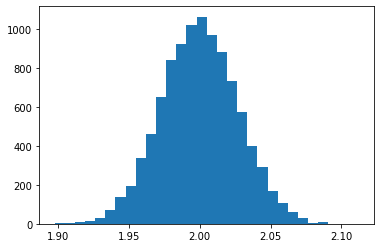

In [197]:
plt.hist(mu_hat_distribution, bins=30);

In [156]:
# check t_mu formula
2*(mb.clone().set_mu(mb.get_mu_MLE(x)).log_prob(x)-mb.log_prob(x))

4156.403000419085

In [198]:
    def sample_test_statistics(sampling_model, testing_model, n_samples=1000, n_jobs=5, 
                               remove_pct_outliers=0.01):
        """
        samples histograms and computes log_prob and t_mu/q_mu for each histogram
        see section 3.1
        
        sampling_model: mu' --> the model from which histograms are sampled
        testing_model:  mu  --> the model with which log_prob and and t_mu/q_mu are computed

        returns a Pandas Dataframe with various test statistics
        """
        def f():
            x              = sampling_model.rvs()
            mu_hat         = testing_model.get_mu_MLE(x)
            logprob_mu     = testing_model.log_prob(x)
            logprob_mu_hat = testing_model.log_prob(x, with_mu=mu_hat)
            t_mu = - 2 * (logprob_mu - logprob_mu_hat) 
            q_mu = t_mu if mu_hat < testing_model.mu else 0 
            
            return logprob_mu, mu_hat, logprob_mu_hat, t_mu, q_mu

        #k = np.r_[rlxutils.mParallel(n_jobs=n_jobs, verbose=30)(delayed(f)() for i in range(n_samples))]
        k = [f() for _ in pbar(range(n_samples))]
        k = pd.DataFrame(k, columns=["logprob_mu", "mu_hat", "logprob_mu_hat", "t_mu", "q_mu"])
        
        if remove_pct_outliers:
            for col in k.columns:
                p_low,p_high = np.percentile(k[col], [100*remove_pct_outliers/2,100*(1-remove_pct_outliers/2)])
                k = k[(k[col]>=p_low)&(k[col]<=p_high)]      
        
        return k

In [259]:
def sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=500, n_jobs=1):
    
    k = sample_test_statistics(sampling_model, testing_model, n_samples=n_samples, n_jobs=n_jobs)
    nc = (testing_model.mu - sampling_model.mu)**2/np.std(k.mu_hat)**2

    tmu_pdf = lambda tmu: (  np.exp(-.5*(np.sqrt(tmu)+np.sqrt(nc))**2) \
                           + np.exp(-.5*(np.sqrt(tmu)-np.sqrt(nc))**2)) \
                          /(2*np.sqrt(tmu)*np.sqrt(2*np.pi))

    eq17 = (testing_model.mu - k.mu_hat)**2/np.std(k.mu_hat)**2
    t_mu_factor = 1/(k.t_mu/eq17).mean() 
    print (f"\nusing t_mu_factor = {t_mu_factor:.4f}")
    print (f"sigma(mu_hat)     = {np.std(k.mu_hat):.4f}")
    print ("corrected nc", nc/t_mu_factor, (testing_model.mu - sampling_model.mu)**2/(np.std(k.mu_hat)*np.sqrt(t_mu_factor))**2)
    plt.figure(figsize=(k.shape[1]*3, 3))
    for i,name in enumerate(k.columns):
        plt.subplot(1,k.shape[1]+1,i+1)
        pdf, pdf_name = None, None
        if name == 'mu_hat':
            pdf = stats.norm(loc=sampling_model.mu, scale=k.mu_hat.std()).pdf
            pdf_name ="Gaussian at $\mu'$"
        if name == "t_mu":
            #pdf = stats.ncx2(df=1, nc = (testing_model.mu - sampling_model.mu)**2/(np.std(k.mu_hat)**2)).pdf
            pdf = tmu_pdf
            pdf_name = f"non-central $\chi^2$\nanalytic nc = {nc:.1f}\nempirical nc = {k.t_mu.mean()-1:.1f}"
            phy.distplot(t_mu_factor*k.values[:,i], bins=25, alpha=.5, pdf=pdf, pdf_name=pdf_name)
        else:
            phy.distplot(k.values[:,i], bins=25, alpha=.5, pdf=pdf, pdf_name=pdf_name)
        plt.title(name)
        if pdf_name is not None:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)

    plt.subplot(1, k.shape[1]+1, k.shape[1]+1)
    
    plt.scatter(eq17,t_mu_factor*k.t_mu, s=10, alpha=.5)
    plt.title("testing eq7")
    plt.xlabel(r"$t_\mu$")
    plt.ylabel(r"$\frac{(\mu-\hat{\mu})^2}{\sigma^2}$")
    plt.grid();

    plt.tight_layout()
    return k

## checking eq 17:  $t_\mu = -2 \log \lambda(\mu) = \frac{(\mu-\hat{\mu})^2}{\sigma^2}$

In [260]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

s_tot, b_tot

(3000, 10000)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06



using t_mu_factor = 0.7757
sigma(mu_hat)     = 0.0126
corrected nc 725.6645366160743 725.6645366160743


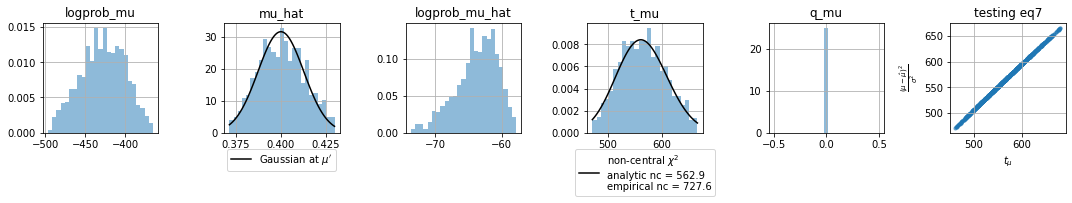

In [289]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.4,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.1)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=1000)

In [281]:
s = 0.0128
tf = 0.7435
print (s/tf)
np.sqrt(1/tf), 1-10*np.log((1+s)**2)

0.017215870880968393


(1.1597370014687192, 0.7456245518445086)

In [275]:
np.log(1.01)

0.009950330853168092

## distributions for a hypothesed $\mu=0.1$ and true $\mu'=0.1$

100% (2000 of 2000) |####################| Elapsed Time: 0:00:11 Time:  0:00:11



using t_mu_factor = 1.2546
sigma(mu_hat)     = 0.0087
corrected nc 0.0 0.0


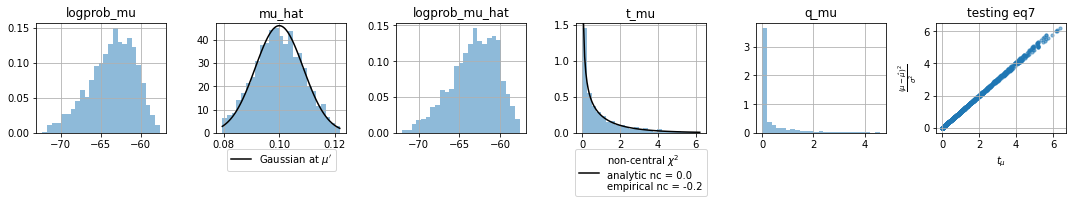

In [282]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.1)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=2000)

## distributions for a hypothesed $\mu=0.15$ and true $\mu'=0.1.$

100% (2000 of 2000) |####################| Elapsed Time: 0:00:10 Time:  0:00:10



using t_mu_factor = 1.4495
sigma(mu_hat)     = 0.0085
corrected nc 23.6976166358929 23.6976166358929


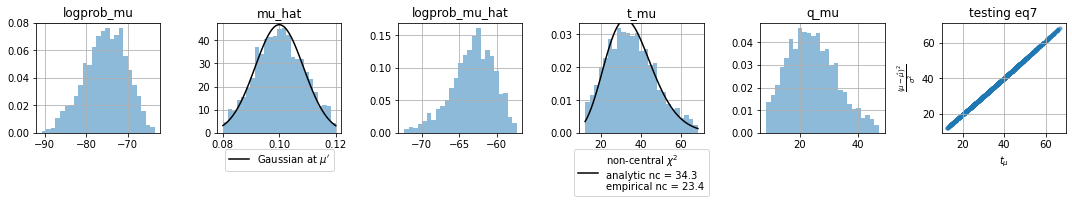

In [284]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.15)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=2000);

## distributions for a hypothesed $\mu=0.3$ and true $\mu'=0.1.$

100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05



using t_mu_factor = 1.6750
sigma(mu_hat)     = 0.0091
corrected nc 291.1021498213573 291.10214982135733


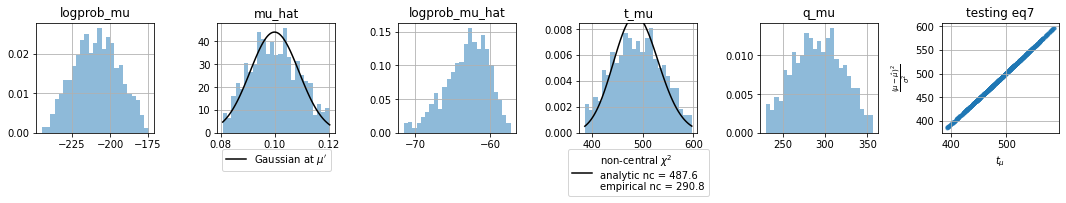

In [373]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.3)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=1000)

In [379]:
eq17 = (testing_model.mu*.76660911 - k.mu_hat)**2/np.std(k.mu_hat)**2
nc = (testing_model.mu - sampling_model.mu*1.1)**2/np.std(k.mu_hat)**2
nc

440.0445072560038

In [380]:
sampling_model.mu

0.1

## distributions for a hypothesed $\mu=0.4$ and true $\mu'=0.1$

100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05



using t_mu_factor = 2.0172
sigma(mu_hat)     = 0.0088
corrected nc 569.7763486318565 569.7763486318565


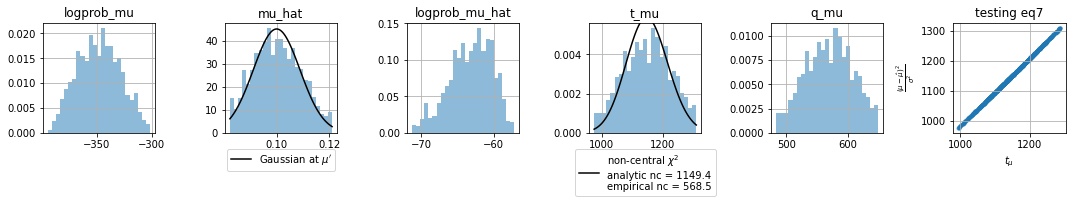

In [384]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.4)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=1000)

In [387]:
eq17 = (testing_model.mu*.76660911 - k.mu_hat)**2/np.std(k.mu_hat)**2
nc = (testing_model.mu - sampling_model.mu*1.6)**2/np.std(k.mu_hat)**2
nc

735.5946898856856

In [386]:
0.1-0.0088

0.0912

## distributions for a hypothesed $\mu=0.5$ and true $\mu'=0.1$

100% (10000 of 10000) |##################| Elapsed Time: 0:00:55 Time:  0:00:55



using t_mu_factor = 2.4373
sigma(mu_hat)     = 0.0085
corrected nc 898.7250291271164 898.7250291271165


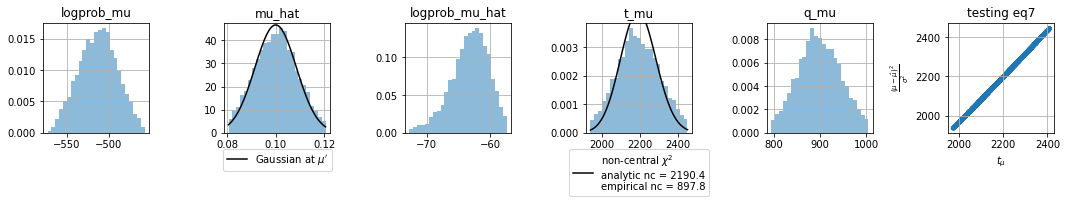

In [287]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.5)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=10000)

## distributions for a hypothesed $\mu=0.3$ and true $\mu'=0.0$

N/A% (0 of 10000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/rlx/Dropbox/proyectos/rlxlibs/rlxml/rlxml/newphysics.py:145: RuntimeWarning: invalid value encountered in log
  r = np.sum(x*np.log(term) - term)
100% (10000 of 10000) |##################| Elapsed Time: 0:00:55 Time:  0:00:55



using t_mu_factor = 2.5397
sigma(mu_hat)     = 0.0070
corrected nc 732.1876564777258 732.1876564777258


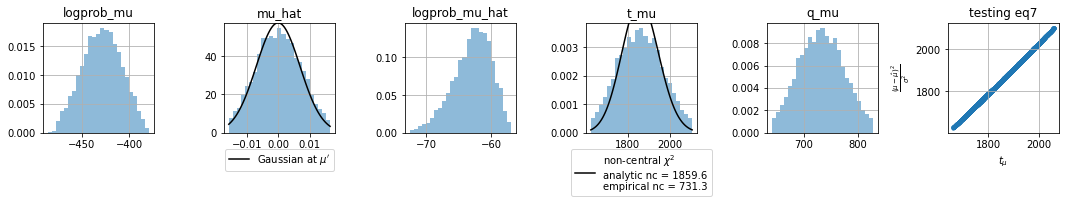

In [288]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.3)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=10000)

## distributions for a hypothesed $\mu=0.7$ and true $\mu'=0.1$

 [mParallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  2.0min finisheders.
using t_mu_factor=1.7618


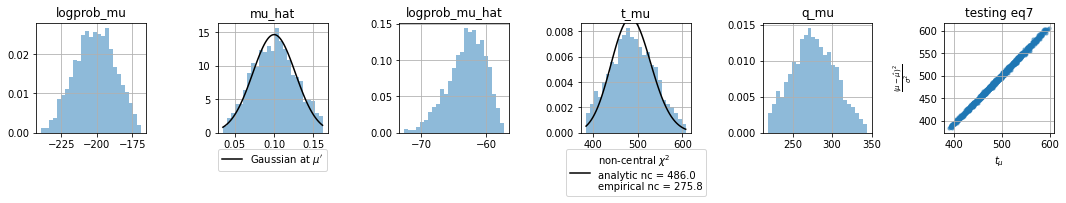

In [94]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.7)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=2000)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:59 Time:  0:00:59



using t_mu_factor = 1.6465
sigma(mu_hat)     = 0.0175
corrected nc 493.00738636021475 493.00738636021464


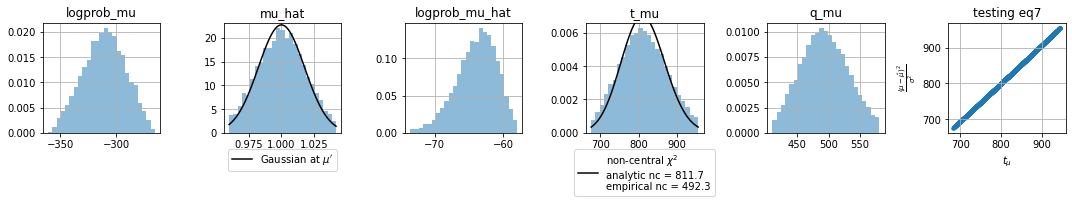

In [388]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=1,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(1.5)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=10000)

N/A% (0 of 1000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/Users/rlx/Dropbox/proyectos/rlxlibs/rlxml/rlxml/newphysics.py:145: RuntimeWarning: invalid value encountered in log
  r = np.sum(x*np.log(term) - term)
100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05



using t_mu_factor = 10.5461
sigma(mu_hat)     = 0.0070
corrected nc 11946.345056084161 11946.34505608416


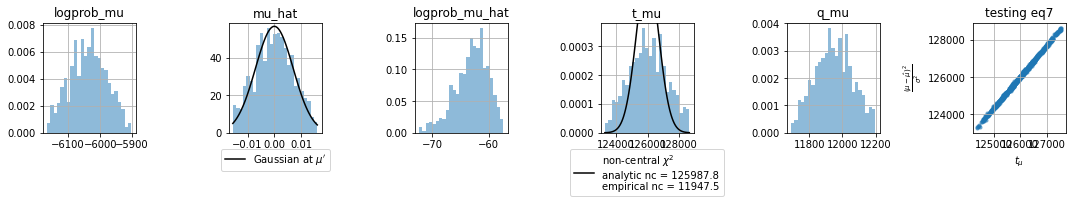

In [390]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(2.5)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=1000)

 [mParallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  2.0min finisheders.
using t_mu_factor=1.1374


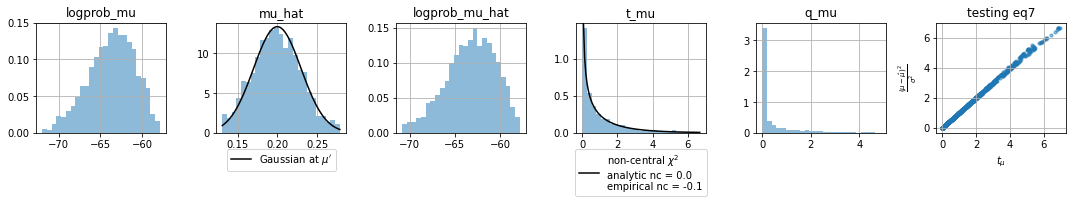

In [97]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.2,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.2)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=2000)

 [mParallel(n_jobs=10)]: Done 2000 out of 2000 | elapsed:  2.0min finisheders.
using t_mu_factor=1.1684


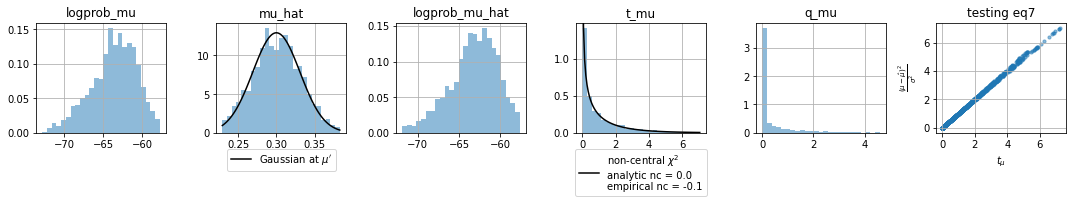

In [103]:
sampling_model = phy.SignalBg_BinnedModel(t=t, mu_s=mu_s, sigma_s=sigma_s, mu=0.3,
                                         bin_edges=bin_edges, s_tot=s_tot, b_tot=b_tot)

testing_model  = sampling_model.clone().set_mu(.3)

k = sample_and_plot_test_statistic(sampling_model, testing_model, n_samples=2000)

the distribution of $t_\mu$ follows a non central $\chi^2$ distribution as in eq 19. Recall that

$$t_\mu = -2 \log \lambda (\mu) = -2 \log \frac{L(\mu, \hat{\hat{\theta}})}{L(\hat{\mu}, \hat{\theta})}$$


for differences between $\mu'$ (the real $\mu$ of sampled data) and $\hat{\mu}$ (the $\mu$ we want to test) > 0.2 approx $\lambda(\mu)$ will be very small and, thus, $t_\mu$ will be very large. I believe that approximation errors when computing $\hat{\mu}$ may lead to discrepacies in the non centrality parameter of the $\chi^2$

In [42]:
eq17 = (testing_model.mu - k2.mu_hat)**2/np.std(k2.mu_hat)**2
t_mu_factor = 1/(k2.t_mu/eq17).mean()
t_mu_factor

0.9470584381858855

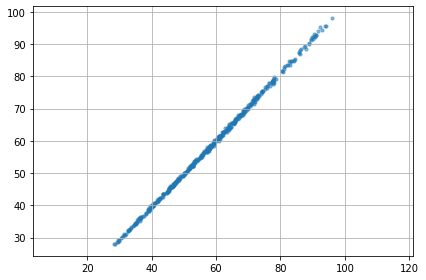

In [40]:
t_mu_factor = 1/(k.t_mu/eq17).mean()

eq17 = (testing_model.mu - k.mu_hat)**2/np.std(k.mu_hat)**2
plt.scatter(eq17,t_mu_factor*k.t_mu, s=10, alpha=.5)
plt.axis("equal")
plt.grid();
plt.tight_layout()


In [39]:
1/(k.t_mu/eq17).mean()

1.4635454033715505